# Wikipedia Articles

### Algorithm - Locality Sensitive Hashing
### Model - TF-IDF Document Representation
### Raw Implementation - no packages used

In [8]:
import numpy as np                                             # dense matrices
import pandas as pd
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
import json
from itertools import combinations
import time

%matplotlib inline


### Loading the data

In [3]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


### TF-IDF matrix

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz') # 59071x547979

print(corpus.shape)

(59071, 547979)


In [5]:
print(wiki.shape)

(59071, 3)


In [10]:
# dict mapping indices to words
with open("people_wiki_map_index_to_word.json") as json_file:
    map_index_to_word = json.load(json_file)  # size = 547979

map_index_to_word = pd.DataFrame(list(map_index_to_word.items()), columns = ['category', 'index'])

### Model  - LSH

#### Generating random lines vectors to split documents into bins

In [11]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)
    
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print(generate_random_vectors(num_vector=3, dim=5))


[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


In [12]:
# Generate 16 random vectors of dimension 547979
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print(random_vectors.shape)

(547979, 16)


In [13]:
# sample
doc = corpus[0, :] # 1x547979 # vector of tf-idf values for document 0

In [14]:
print(doc.dot(random_vectors[:, 0]) >= 0) # True if positive sign; False if negative sign    

[ True]


In [15]:
print(doc.dot(random_vectors[:, 1]) >= 0) # True if positive sign; False if negative sign

[ True]


In [16]:
# vectorize
print(doc.dot(random_vectors) >= 0) # should return an array of 16 True/False bits
print(np.array(doc.dot(random_vectors) >= 0, dtype=int)) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


In [17]:
print(corpus[0:2].dot(random_vectors) >= 0)# compute bit indices of first two documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]


In [18]:
print(corpus.dot(random_vectors) >= 0) # compute bit indices of ALL documents # shape is  (59071, 16)

[[ True  True False ...  True False  True]
 [ True False False ... False False  True]
 [False  True False ...  True False  True]
 ...
 [ True  True False ...  True  True  True]
 [False  True  True ...  True False  True]
 [ True False  True ... False False  True]]


We're almost done! To make it convenient to refer to individual bins, we convert each binary bin index into a single integer: 
```
Bin index                      integer
[0,0,0,0,0,0,0,0,0,0,0,0]   => 0
[0,0,0,0,0,0,0,0,0,0,0,1]   => 1
[0,0,0,0,0,0,0,0,0,0,1,0]   => 2
[0,0,0,0,0,0,0,0,0,0,1,1]   => 3
...
[1,1,1,1,1,1,1,1,1,1,0,0]   => 65532
[1,1,1,1,1,1,1,1,1,1,0,1]   => 65533
[1,1,1,1,1,1,1,1,1,1,1,0]   => 65534
[1,1,1,1,1,1,1,1,1,1,1,1]   => 65535 (= 2^16-1)
```
By the [rules of binary number representation](https://en.wikipedia.org/wiki/Binary_number#Decimal), we just need to compute the dot product between the document vector and the vector consisting of powers of 2:

In [19]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print(index_bits)
print(powers_of_two)           # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print(index_bits.dot(powers_of_two))

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [21]:
# vectorize -- across all examples
index_bits = corpus.dot(random_vectors) >= 0 #  (59071, 16)
print(index_bits.dot(powers_of_two))# (59071,)
print(index_bits.dot(powers_of_two).shape)

[50917 36265 19365 ... 52983 27589 41449]
(59071,)


In [22]:
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0) # (59071, 16)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)   # (59071,)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index) # YOUR CODE HERE

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [23]:
model = train_lsh(corpus, num_vector=16, seed=143)

In [24]:
table = model['table']

In [25]:
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print('Passed!')
else:
    print('Check your code.')

Passed!


In [27]:
wiki[wiki['name'] == 'Barack Obama']

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


In [33]:
# Find Obama's bin

for k,v in table.items():
    if 35817 in v:
        print(k)

50194


In [37]:
# Obama
print(np.array(model['bin_index_bits'][35817], dtype=int)) # list of 0/1's
# print([model['bin_indices'][35817]])

# Joe Biden
# print(wiki[wiki['name'] == 'Joe Biden'])
print(np.array(model['bin_index_bits'][24478], dtype=int))

# Hugh-Jones
# print(wiki[wiki['name']=='Wynn Normington Hugh-Jones'])
print(np.array(model['bin_index_bits'][22745], dtype=int)) # list of 0/1's

[1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0]
[1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]


In [38]:
print(np.sum(model['bin_index_bits'][35817] == model['bin_index_bits'][24478]))
print(np.sum(model['bin_index_bits'][35817] == model['bin_index_bits'][22745]))

14
8


In [41]:
# indices of documents in the same bin as obama doc
print(model['table'][model['bin_indices'][35817]])

[21426, 35817, 39426, 50261, 53937]


In [42]:
# display documents other than Obama
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817)
docs = wiki.iloc[doc_ids] 
docs

,URI,name,text
21426,<http://dbpedia.org/resource/Mark_Boulware>,Mark Boulware,mark boulware born 1948 is an american diploma...
39426,<http://dbpedia.org/resource/John_Wells_(polit...,John Wells (politician),sir john julius wells born 30 march 1925 is a ...
50261,<http://dbpedia.org/resource/Francis_Longstaff>,Francis Longstaff,francis a longstaff born august 3 1956 is an a...
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv...,Madurai T. Srinivasan,maduraitsrinivasan is a wellknown figure in th...


In [43]:
def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return norm
    

In [44]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

In [45]:
obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print('================= Cosine distance from Barack Obama')
print('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf)))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139


In [46]:
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print('Barack Obama - {0:24s}: {1:f}'.format(wiki.iloc[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf)))

Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


## Query the LSH model

Let us first implement the logic for searching nearby neighbors, which goes like this:
```
1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.
...
```

To obtain candidate bins that differ from the query bin by some number of bits, we use `itertools.combinations`, which produces all possible subsets of a given list. See [this documentation](https://docs.python.org/3/library/itertools.html#itertools.combinations) for details.
```
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.
```

Each line of output from the following cell is a 3-tuple indicating where the candidate bin would differ from the query bin. For instance,
```
(0, 1, 3)
```
indicates that the candiate bin differs from the query bin in first, second, and fourth bits.

In [47]:
num_vector = 16
search_radius = 3

for diff in combinations(range(num_vector), search_radius): ## 560 items
    print(diff)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [48]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = alternate_bits[i] == 0 # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            candidate_set.update(model['table'][nearby_bin])
            
    return candidate_set

In [49]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
candidate_set

{21426, 35817, 39426, 50261, 53937}

In [51]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
candidate_set

{2804,
 9757,
 19699,
 20347,
 21426,
 21715,
 21975,
 23229,
 27404,
 28444,
 33243,
 33996,
 34547,
 35817,
 38155,
 38412,
 39207,
 39426,
 39877,
 41631,
 45676,
 47773,
 50261,
 53937,
 55615,
 58723,
 59050}

In [52]:
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print('Passed test')
else:
    print('Check your code')

Passed test


In [53]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame({'id':list(candidate_set)})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by = 'distance', ascending=True)[:k], len(candidate_set)

print(query(corpus[35817,:], model, k=10, max_search_radius=3))

(        id  distance
369  35817  0.000000
704  24478  0.703139
267  56008  0.856848
132  37199  0.874669
515  40353  0.890034
390   9267  0.898377
228  55909  0.899340
359   9165  0.900921
229  57958  0.903003
269  49872  0.909533, 727)


In [54]:
print(query(corpus[35817,:], model, k=10, max_search_radius=3))

(        id  distance
369  35817  0.000000
704  24478  0.703139
267  56008  0.856848
132  37199  0.874669
515  40353  0.890034
390   9267  0.898377
228  55909  0.899340
359   9165  0.900921
229  57958  0.903003
269  49872  0.909533, 727)


In [55]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
print(result.join(wiki[[ 'name']], on='id').sort_values(by = 'distance'))

        id  distance                     name
369  35817  0.000000             Barack Obama
704  24478  0.703139                Joe Biden
267  56008  0.856848            Nathan Cullen
132  37199  0.874669  Barry Sullivan (lawyer)
515  40353  0.890034            Neil MacBride
390   9267  0.898377      Vikramaditya Khanna
228  55909  0.899340              Herman Cain
359   9165  0.900921     Raymond F. Clevenger
229  57958  0.903003        Michael J. Malbin
269  49872  0.909533            Lowell Barron


In [56]:
import time
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print('Radius:', max_search_radius)
    # Display 10 nearest neighbors, along with document ID and name
    print(result.join(wiki[[ 'name']], on='id').sort_values(by = 'distance'))
    #print(result.join(wiki[['id', 'name']], on='id').sort('distance'))
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
      id  distance                     name
1  35817  0.000000             Barack Obama
3  21426  0.950867            Mark Boulware
0  39426  0.975966  John Wells (politician)
4  50261  0.978256        Francis Longstaff
2  53937  0.993092    Madurai T. Srinivasan
Radius: 1
       id  distance                                   name
16  35817  0.000000                           Barack Obama
13  41631  0.947459                            Binayak Sen
20  21426  0.950867                          Mark Boulware
9   33243  0.951766                        Janice Lachance
3   33996  0.960859                            Rufus Black
10  28444  0.961081                       John Paul Phelan
24  20347  0.974130                        Gianni De Fraja
0   39426  0.975966                John Wells (politician)
23  34547  0.978215  Nathan Murphy (Australian politician)
7   50261  0.978256                      Francis Longstaff
Radius: 2
        id  distance                 name
135  35817  0.0

Radius: 16
          id  distance                     name
35817  35817  0.000000             Barack Obama
24478  24478  0.703139                Joe Biden
38376  38376  0.742982           Samantha Power
57108  57108  0.758358   Hillary Rodham Clinton
38714  38714  0.770561  Eric Stern (politician)
46140  46140  0.784678             Robert Gibbs
6796    6796  0.788039              Eric Holder
44681  44681  0.790926   Jesse Lee (politician)
18827  18827  0.798323             Henry Waxman
2412    2412  0.799466          Joe the Plumber


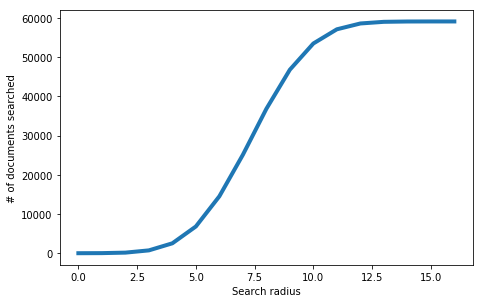

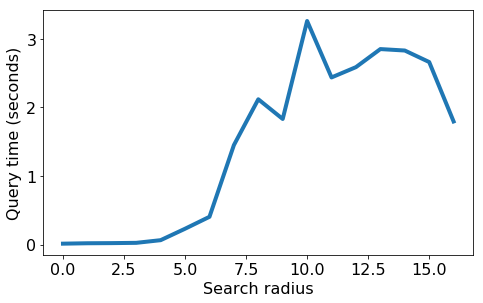

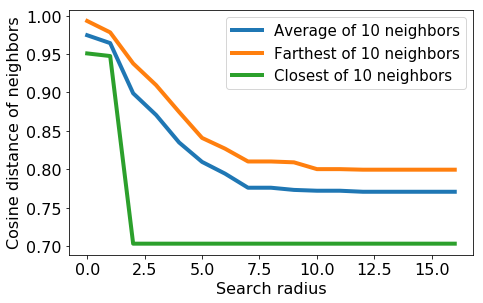

In [57]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Quality metrics for neighbors

The above analysis is limited by the fact that it was run with a single query, namely Barack Obama. We should repeat the analysis for the entirety of data. Iterating over all documents would take a long time, so let us randomly choose 10 documents for our analysis.

For each document, we first compute the true 25 nearest neighbors, and then run LSH multiple times. We look at two metrics:

* Precision@10: How many of the 10 neighbors given by LSH are among the true 25 nearest neighbors?
* Average cosine distance of the neighbors from the query

Then we run LSH multiple times with different search radii.

In [59]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by = 'distance', ascending=True)[:k]


max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())


0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


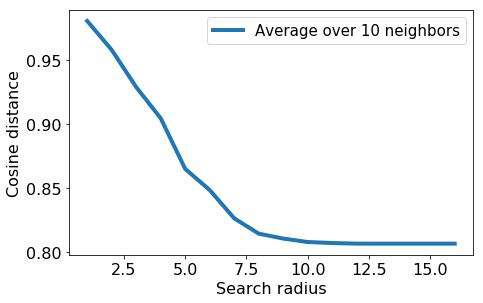

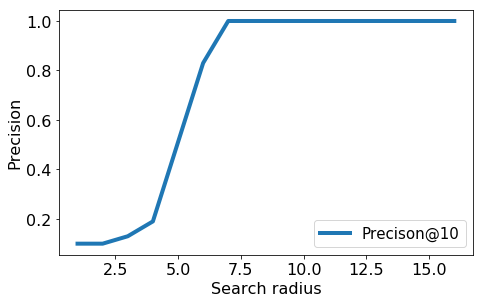

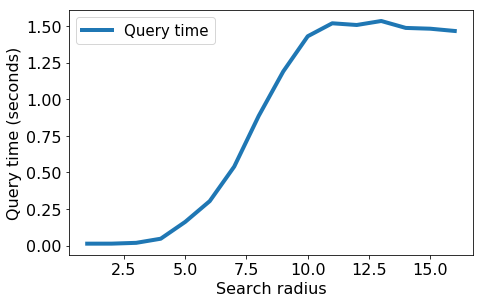

In [60]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

## Effect of number of random vectors
Let us now turn our focus to the remaining parameter: the number of random vectors. We run LSH with different number of random vectors, ranging from 5 to 20. We fix the search radius to 3.

Allow a few minutes for the following cell to complete.

In [61]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)


num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


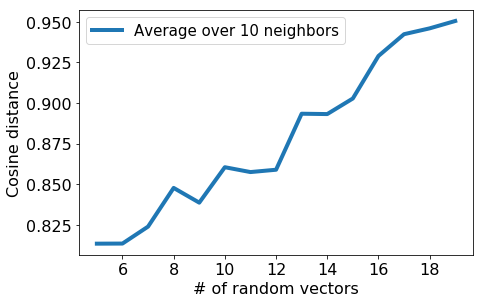

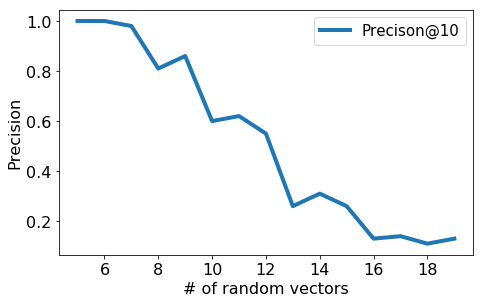

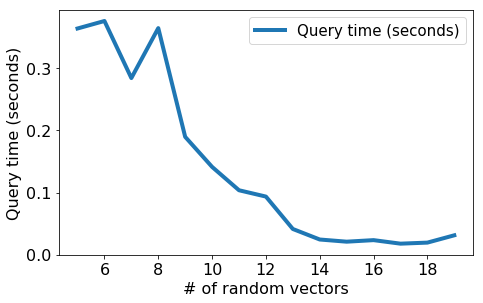

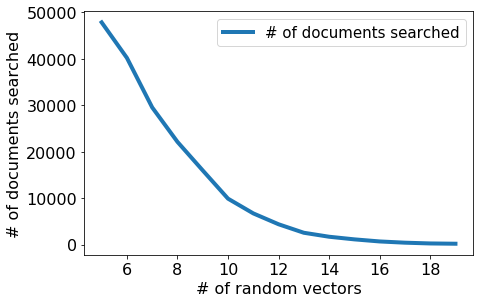

In [62]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()